In [33]:
# fix python path if working locally
# from utils import fix_pythonpath_if_working_locally

# fix_pythonpath_if_working_locally()

import logging

import matplotlib.pyplot as plt
import numpy as np
import torch

from darts import concatenate
from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset, ElectricityDataset, MonthlyMilkDataset
from darts.metrics import mae, mape
from darts.models import (
    VARIMA,
    BlockRNNModel,
    NBEATSModel,
    RNNModel,
)
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (
    datetime_attribute_timeseries,
    sine_timeseries,
)

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

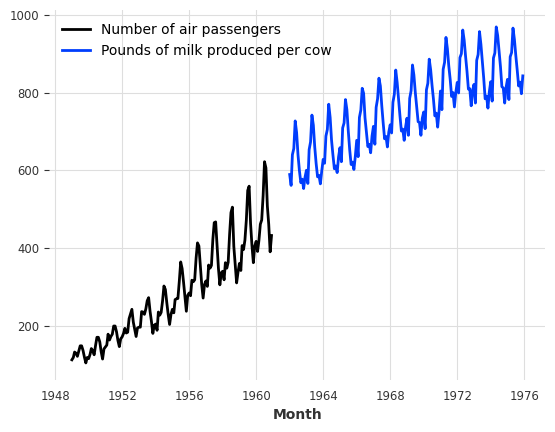

In [34]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();

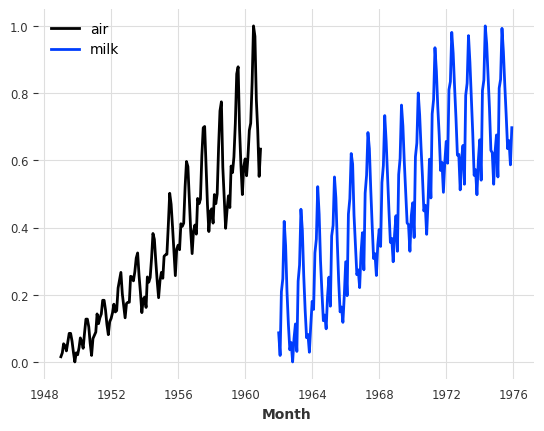

In [35]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

In [36]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

In [37]:
model_air = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=200,
    random_state=0,
    **generate_torch_kwargs(),
)

In [38]:
model_air.fit(train_air)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=200, random_state=0, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7ff37b25c1a0>]})

In [45]:
import pandas as pd

data = {
    "sales_order_id": ['abc', 'abc', 'abc', 'abc', 'abc', 'abc'],
    "Name": ["black shirt", "blue jeans", "wallet", "cap", "chain", "ring"],
    "Seller": ["A", "B", "B", "A", "C", "A"]
}

df = pd.DataFrame(data)

print(df)


  sales_order_id         Name Seller
0            abc  black shirt      A
1            abc   blue jeans      B
2            abc       wallet      B
3            abc          cap      A
4            abc        chain      C
5            abc         ring      A


In [46]:
import duckdb

duckdb.query(
    """
    select *
    , concat(sales_order_id, Seller) as key
    , count( distinct concat(sales_order_id, Seller)) as parent_order
    , COUNT(DISTINCT Seller) OVER (PARTITION BY sales_order_id) AS parent_order
    from df
    group by sales_order_id, Name, Seller
"""
)

┌────────────────┬─────────────┬─────────┬─────────┬──────────────┬──────────────┐
│ sales_order_id │    Name     │ Seller  │   key   │ parent_order │ parent_order │
│    varchar     │   varchar   │ varchar │ varchar │    int64     │    int64     │
├────────────────┼─────────────┼─────────┼─────────┼──────────────┼──────────────┤
│ abc            │ ring        │ A       │ abcA    │            1 │            3 │
│ abc            │ blue jeans  │ B       │ abcB    │            1 │            3 │
│ abc            │ wallet      │ B       │ abcB    │            1 │            3 │
│ abc            │ chain       │ C       │ abcC    │            1 │            3 │
│ abc            │ cap         │ A       │ abcA    │            1 │            3 │
│ abc            │ black shirt │ A       │ abcA    │            1 │            3 │
└────────────────┴─────────────┴─────────┴─────────┴──────────────┴──────────────┘

In [51]:
import duckdb

duckdb.query(
    """
    select sales_order_id, Seller
    , count( distinct concat(sales_order_id, Seller)) as parent_order
    , COUNT(DISTINCT Seller) OVER (PARTITION BY sales_order_id) AS parent_order
    from df
    group by sales_order_id, Seller
"""
)

┌────────────────┬─────────┬──────────────┬──────────────┐
│ sales_order_id │ Seller  │ parent_order │ parent_order │
│    varchar     │ varchar │    int64     │    int64     │
├────────────────┼─────────┼──────────────┼──────────────┤
│ abc            │ C       │            1 │            3 │
│ abc            │ B       │            1 │            3 │
│ abc            │ A       │            1 │            3 │
└────────────────┴─────────┴──────────────┴──────────────┘